# 1/ Import libraries

In [157]:
import pandas as pd
import pandas._typing
import numpy as np
import mlflow
import seaborn as sns
import xgboost as xgb
import optuna
import warnings
warnings.simplefilter('ignore')
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from typing import cast
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
from IPython.display import display
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

# 2/ Dataset Exploration

In [158]:
# Load the datasets
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [159]:
train0 = train.drop("loan_status", axis=1)
train0

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


In [160]:
# Combine the test and train datasets for consistent preprocessing
both = pd.concat([test, train0], axis=0)
both.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [ ]:
# Function to filter out individuals older than 65
def remove_age(both):
    return both[both['person_age'] <= 65]

# Remove individuals older than 65 years from the dataset
combine = remove_age(both)

# Display the cleaned dataset
combine

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


In [162]:
# Display information about the dataset
combine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97611 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          97611 non-null  int64  
 1   person_age                  97611 non-null  int64  
 2   person_income               97611 non-null  int64  
 3   person_home_ownership       97611 non-null  object 
 4   person_emp_length           97611 non-null  float64
 5   loan_intent                 97611 non-null  object 
 6   loan_grade                  97611 non-null  object 
 7   loan_amnt                   97611 non-null  int64  
 8   loan_int_rate               97611 non-null  float64
 9   loan_percent_income         97611 non-null  float64
 10  cb_person_default_on_file   97611 non-null  object 
 11  cb_person_cred_hist_length  97611 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.7+ MB


In [163]:
combine.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,97611.000000,97611.000000,9.761100e+04,97611.000000,97611.000000,97611.000000,97611.000000,97611.000000
mean,48874.281167,27.504124,6.404327e+04,4.696090,9229.712860,10.670302,0.159365,5.796283
std,28215.083904,5.855639,3.793707e+04,3.920527,5566.577504,3.028261,0.091657,3.992971
min,0.000000,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,24442.500000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,48877.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,73307.500000,30.000000,7.561900e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,60.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


In [164]:
combine.dropna()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


# a) Data Cleaning

In [165]:
# Fill missing values in numerical columns with the column mean
filled = combine.fillna(combine.mean(numeric_only=True))
filled

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


In [166]:
# Remove duplicates in the dataset
no_duplicates = filled.drop_duplicates()
no_duplicates

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


# b) Export the combine dataset

In [167]:
# Exporter le DataFrame vers un fichier xlsx
no_duplicates.to_excel('All_data.xlsx', index=False)

# C) Plotting variables

In [168]:
df = pd.read_excel("All_data.xlsx")

Text(0.5, 1.0, 'Distribution of Loan Amount')

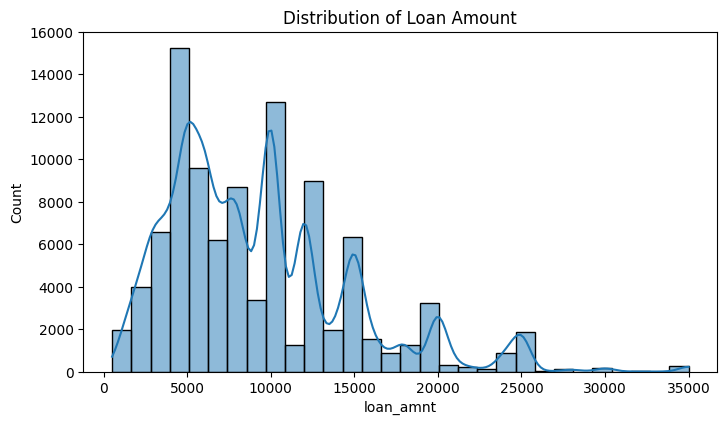

In [169]:
# Set up the plotting environment
plt.figure(figsize=(18, 15))

# Distribution of the target variable (loan_amnt)
plt.subplot(3, 2, 1)
sns.histplot(df['loan_amnt'], kde=True, bins=30)
plt.title('Distribution of Loan Amount')

Text(0.5, 1.0, 'Distribution of Applicant Age')

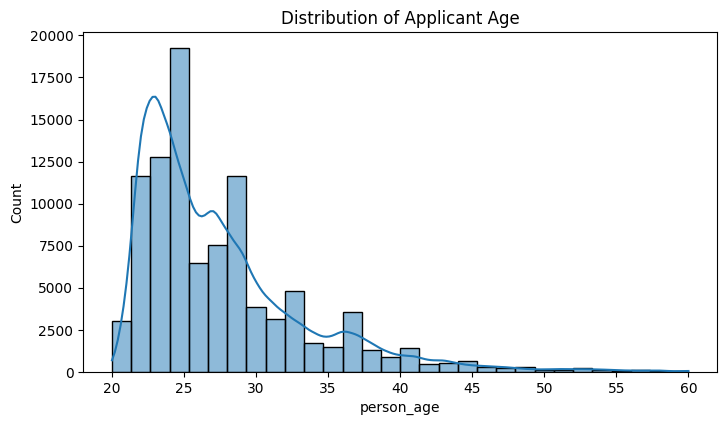

In [170]:
# Set up the plotting environment
plt.figure(figsize=(18, 15))

# Age distribution
plt.subplot(3, 2, 2)
sns.histplot(df['person_age'], kde=True, bins=30)
plt.title('Distribution of Applicant Age')

Text(0.5, 1.0, 'Distribution of Applicant Income')

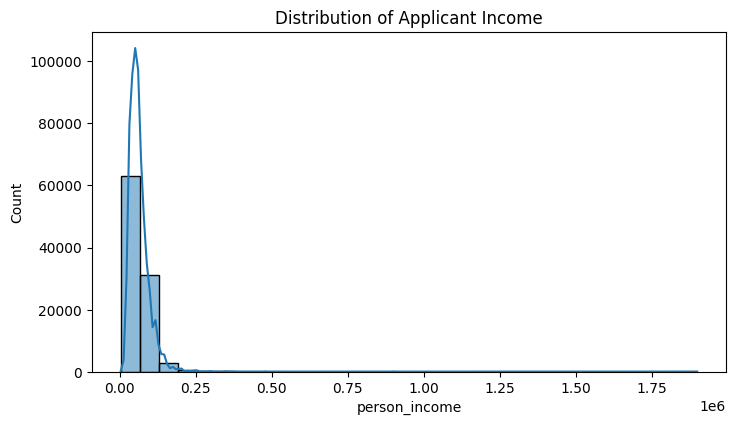

In [171]:
plt.figure(figsize=(18, 15))

# Income distribution
plt.subplot(3, 2, 3)
sns.histplot(df['person_income'], kde=True, bins=30)
plt.title('Distribution of Applicant Income')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'HOMEIMPROVEMENT'),
  Text(1, 0, 'PERSONAL'),
  Text(2, 0, 'VENTURE'),
  Text(3, 0, 'DEBTCONSOLIDATION'),
  Text(4, 0, 'EDUCATION'),
  Text(5, 0, 'MEDICAL')])

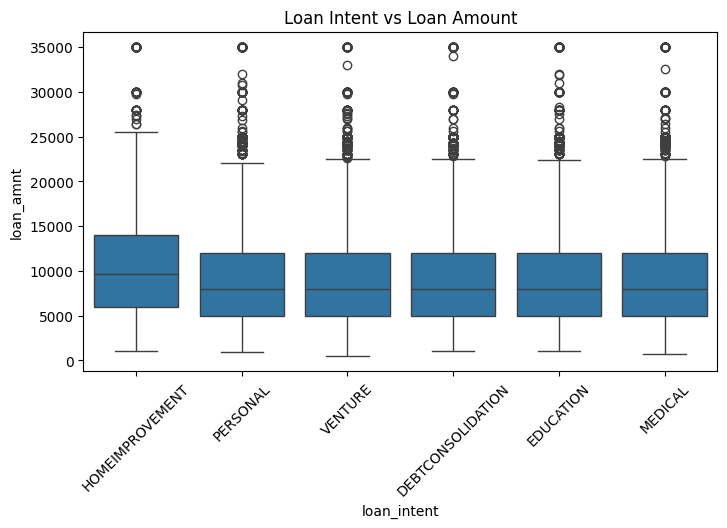

In [172]:
# Set up the plotting environment
plt.figure(figsize=(18, 15))

# Loan intent vs. Loan amount
plt.subplot(3, 2, 4)
sns.boxplot(x='loan_intent', y='loan_amnt', data=df)
plt.title('Loan Intent vs Loan Amount')
plt.xticks(rotation=45)

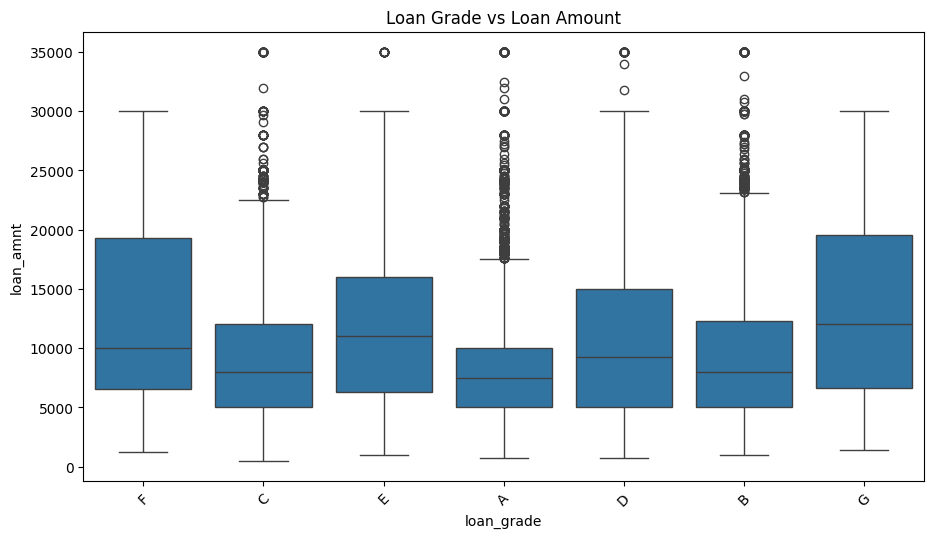

In [173]:
# Set up the plotting environment
plt.figure(figsize=(18, 15))

# Loan grade vs. Loan amount
plt.subplot(3, 2, 5)
sns.boxplot(x='loan_grade', y='loan_amnt', data=df)
plt.title('Loan Grade vs Loan Amount')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# d) Conversion of categorical variables and correlation matrix

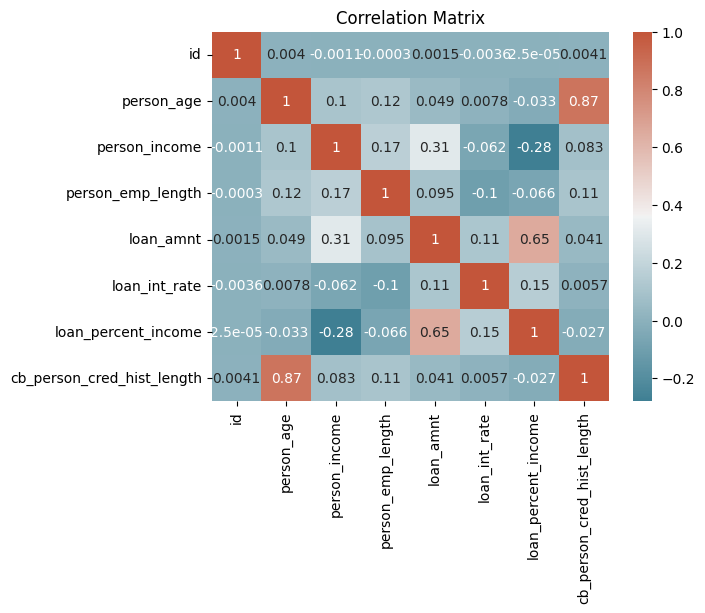

In [174]:
# Generate a correlation matrix for numerical features
Change = df.select_dtypes(include=['number'])
correlation = Change.corr()
sns.heatmap(correlation, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title("Correlation Matrix")
plt.show()

# 3/ Baseline Machine Learning (Logistic Regression)

# a) Outliers detection

In [175]:
# Fonction pour vérifier la présence d'outliers
def has_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound).any() or (column > upper_bound).any()

# Vérifier les outliers pour toutes les colonnes numériques
outlier_results = {column: has_outliers_iqr(df[column]) for column in df.select_dtypes(include='number').columns}

# Afficher le résultat
for column, has_outlier in outlier_results.items():
    print(f"Do we have outlier in column '{column}'? {'Yes' if has_outlier else 'No'}")

Do we have outlier in column 'id'? No
Do we have outlier in column 'person_age'? Yes
Do we have outlier in column 'person_income'? Yes
Do we have outlier in column 'person_emp_length'? Yes
Do we have outlier in column 'loan_amnt'? Yes
Do we have outlier in column 'loan_int_rate'? Yes
Do we have outlier in column 'loan_percent_income'? Yes
Do we have outlier in column 'cb_person_cred_hist_length'? Yes


# b) Outliers suppression


In [176]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(df):
    for column in df.select_dtypes(include='number').columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Remove outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from the dataset
no_outliers = remove_outliers_iqr(df)
no_outliers

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,58646,26,96000,MORTGAGE,6,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
5,58650,23,66000,RENT,5,EDUCATION,D,22000,14.09,0.33,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
97605,58639,22,70000,RENT,6,DEBTCONSOLIDATION,A,10000,7.29,0.14,N,4
97607,58641,28,28800,RENT,0,MEDICAL,C,10000,12.73,0.35,N,8
97608,58642,23,44000,RENT,7,EDUCATION,D,6800,16.00,0.15,N,2
97609,58643,22,30000,RENT,2,EDUCATION,A,5000,8.90,0.17,N,3


# c) Train Test Split

In [177]:
no_outliers.shape

(81264, 12)

In [178]:
no_outliers.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')

In [179]:
target_variable = 'loan_amnt'  # Target variable

# Define features and target variable
X = no_outliers.drop(columns=[target_variable])  # Features (all columns except the target)
y = no_outliers[target_variable]                  # Target variable

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,            # 20% for testing
    random_state=42           # For reproducibility
)

# Display the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (65011, 11) (65011,)
Testing set shape: (16253, 11) (16253,)


# d) Baseline (regression)

In [180]:
# Define features and target (use loan_amnt for regression instead of loan_status)
X = df.drop(columns=['loan_amnt'])  # Drop the target column (loan_amnt)
y = df['loan_amnt']                 # Target variable (loan amount)

# Define the actual numerical and categorical columns
numeric_features = ['person_age', 'person_income', 'person_emp_length', 
                    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Scaling numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encoding categorical features
    ])

# Create a Random Forest model for regression
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Use Regressor instead of Classifier

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)  # Changed to regressor
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Squared Error: 796591.6349184188
R² Score: 0.9744277036663588


Mean Squared Error: 17721901.564574692
R2 Score: 0.12697859628499197
               Coefficient
person_age        0.788655
person_income     0.069356
loan_int_rate   171.522481


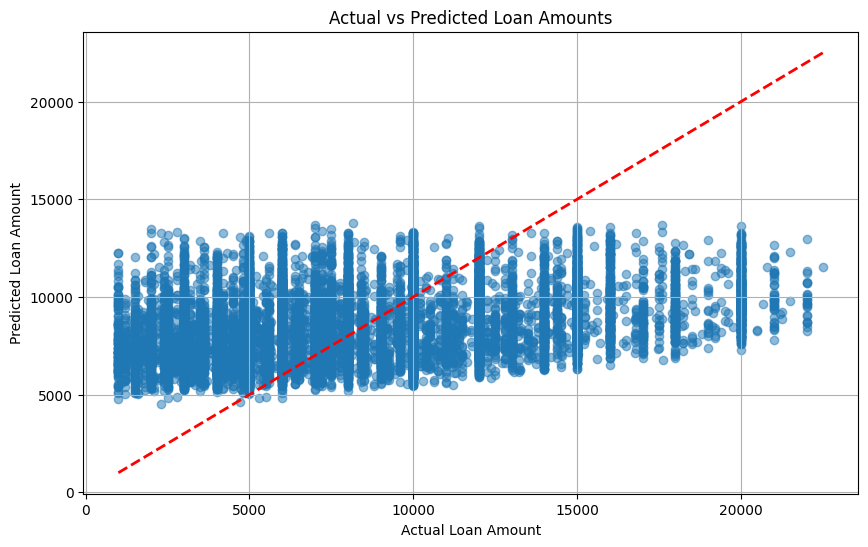

In [181]:
# Select explanatory variables
X = no_outliers[['person_age', 'person_income', 'loan_int_rate']]  # Features
y = no_outliers['loan_amnt']  # Target variable

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

# Coefficients du modèle
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs Predicted Loan Amounts')
plt.xlabel('Actual Loan Amount')
plt.ylabel('Predicted Loan Amount')
plt.grid(True)
plt.show()

# 4/ Iterations

In [182]:
# Define a function to train, predict, and evaluate models
def train_and_evaluate(model, model_name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'{model_name} - Mean Squared Error: {mse:.4f}')
    print(f'{model_name} - R² Score: {r2:.4f}')
    print('-------------------------------------------')

# a) Linear regression

In [183]:
# Sélectionner les caractéristiques et la cible
features = no_outliers[['person_age', 'person_income', 'person_home_ownership',
                  'person_emp_length', 'loan_intent', 'loan_grade', 
                  'loan_int_rate', 'loan_percent_income', 
                  'cb_person_default_on_file', 'cb_person_cred_hist_length']]
target = no_outliers['loan_amnt']  # Cible : montant du prêt

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Définir le préprocesseur
numerical_features = ['person_age', 'person_income', 'person_emp_length', 
                      'loan_int_rate', 'loan_percent_income', 
                      'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 
                        'cb_person_default_on_file']  # Assurez-vous que c'est une caractéristique catégorielle

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the function to train, predict, and evaluate models
def train_and_evaluate(model, model_name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'{model_name} - Mean Squared Error: {mse:.4f}')
    print(f'{model_name} - R² Score: {r2:.4f}')
    print('-------------------------------------------')

# Exemple d'utilisation avec différents modèles
train_and_evaluate(LinearRegression(), 'Linear Regression')
train_and_evaluate(XGBRegressor(), 'XGBoost Regressor')

Linear Regression - Mean Squared Error: 2789327.4052
Linear Regression - R² Score: 0.8626
-------------------------------------------
XGBoost Regressor - Mean Squared Error: 180936.6741
XGBoost Regressor - R² Score: 0.9911
-------------------------------------------


In [184]:
# Ridge Regression
train_and_evaluate(Ridge(alpha=1.0), "Ridge Regression")

Ridge Regression - Mean Squared Error: 2789369.6258
Ridge Regression - R² Score: 0.8626
-------------------------------------------


In [185]:
# Random Forest Regressor
train_and_evaluate(RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest Regressor")

Random Forest Regressor - Mean Squared Error: 176769.5727
Random Forest Regressor - R² Score: 0.9913
-------------------------------------------


In [186]:
# HistGradientBoostingRegressor
train_and_evaluate(HistGradientBoostingRegressor(random_state=42), "HistGradient Boosting Regressor")

HistGradient Boosting Regressor - Mean Squared Error: 203679.7320
HistGradient Boosting Regressor - R² Score: 0.9900
-------------------------------------------


In [187]:
# XGBoost Regressor
train_and_evaluate(xgb.XGBRegressor(random_state=42), "XGBoost Regressor")

XGBoost Regressor - Mean Squared Error: 180936.6741
XGBoost Regressor - R² Score: 0.9911
-------------------------------------------


# a) K-Fold Validation

In [188]:
# Sélectionner les caractéristiques et la cible
features = no_outliers[['person_age', 'person_income', 'person_home_ownership',
                  'person_emp_length', 'loan_intent', 'loan_grade', 
                  'loan_int_rate', 'loan_percent_income', 
                  'cb_person_default_on_file', 'cb_person_cred_hist_length']]
target = no_outliers['loan_amnt']  # Cible : montant du prêt

# Définir le préprocesseur
numerical_features = ['person_age', 'person_income', 'person_emp_length', 
                      'loan_int_rate', 'loan_percent_income', 
                      'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 
                        'cb_person_default_on_file']  # Assurez-vous que c'est une caractéristique catégorielle

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the function to train, predict, and evaluate models
def train_and_evaluate(model, model_name, X, y):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        pipeline.fit(X_train_kf, y_train_kf)
        
        # Make predictions
        y_pred = pipeline.predict(X_test_kf)
        
        # Evaluate the model
        mse = mean_squared_error(y_test_kf, y_pred)
        r2 = r2_score(y_test_kf, y_pred)
        
        mse_scores.append(mse)
        r2_scores.append(r2)

    print(f'{model_name} - Mean Squared Error: {np.mean(mse_scores):.4f}')
    print(f'{model_name} - R² Score: {np.mean(r2_scores):.4f}')
    print('-------------------------------------------')

# Exemple d'utilisation avec différents modèles
train_and_evaluate(LinearRegression(), 'Linear Regression', features, target)
train_and_evaluate(XGBRegressor(), 'XGBoost Regressor', features, target)

Linear Regression - Mean Squared Error: 2772170.5170
Linear Regression - R² Score: 0.8625
-------------------------------------------
XGBoost Regressor - Mean Squared Error: 166668.9618
XGBoost Regressor - R² Score: 0.9917
-------------------------------------------


# Experiment Tracking : Optuna

In [189]:
# Créer un préprocesseur
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Standardisation des caractéristiques numériques
        ('cat', OneHotEncoder(), categorical_features)  # Encodage des caractéristiques catégorielles
    ])


In [190]:
def objective(trial):
    try:
        C = trial.suggest_loguniform('C', 1e-5, 1e5)
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
        
        model = LogisticRegression(C=C, solver=solver, max_iter=1000)
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy
    except Exception as e:
        print(f"Error during training: {e}")
        return 0.0  # Ou une autre valeur par défaut

In [191]:
# Fonction d'optimisation des hyperparamètres
def objective(trial):
    try:
    # Choisir les hyperparamètres à optimiser
        C = trial.suggest_loguniform('C', 1e-5, 1e5)
        solver = trial.suggest_categorical('solver', ['saga'])
    
    # Créer le modèle avec les hyperparamètres
        model = LogisticRegression(C=C, solver=solver, max_iter=1000)

    # Créer un pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

    # Entraîner le modèle
        pipeline.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
        y_pred = pipeline.predict(X_test)

    # Calculer la précision
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy
    
    except Exception as e:
        print(f"Error during training: {e}")
        return 0.0  # Ou une autre valeur par défaut

# Créer une étude Optuna
study = optuna.create_study(direction='maximize')  # Maximiser la précision
study.optimize(objective, n_trials=24)  # Nombre d'essais

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", study.best_params)
print("Meilleure précision : ", study.best_value)

[I 2024-11-02 22:03:48,514] A new study created in memory with name: no-name-4ff24095-500f-4a41-9f7f-7d937af90ca5
[I 2024-11-02 22:03:48,514] Trial 0 finished with value: 0.0 and parameters: {'C': 0.014343733572998346, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,518] Trial 1 finished with value: 0.0 and parameters: {'C': 40.89209875061636, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,518] Trial 2 finished with value: 0.0 and parameters: {'C': 931.3973467684878, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,523] Trial 3 finished with value: 0.0 and parameters: {'C': 0.0014039114234186334, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,525] Trial 4 finished with value: 0.0 and parameters: {'C': 0.00042162741580287276, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,527] Trial 5 finished with value: 0.0 and parameters: {'C': 0.003671724778268973,

Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error 

In [192]:
# Fonction d'optimisation des hyperparamètres
def objective(trial):
    try:
    # Choisir les hyperparamètres à optimiser
        C = trial.suggest_loguniform('C', 1e-5, 1e5)
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Créer le modèle avec les hyperparamètres
        model = LogisticRegression(C=C, solver=solver, max_iter=1000)

    # Créer un pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

    # Entraîner le modèle
        pipeline.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
        y_pred = pipeline.predict(X_test)

    # Calculer la précision
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy
    
    except Exception as e:
        print(f"Error during training: {e}")
        return 0.0  # Ou une autre valeur par défaut

# Créer une étude Optuna
study = optuna.create_study(direction='maximize')  # Maximiser la précision
study.optimize(objective, n_trials=100)  # Nombre d'essais

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", study.best_params)
print("Meilleure précision : ", study.best_value)

[I 2024-11-02 22:03:48,633] A new study created in memory with name: no-name-65f7ee97-6110-4326-8b15-01b707ea6c09
[I 2024-11-02 22:03:48,643] Trial 0 finished with value: 0.0 and parameters: {'C': 36.0999788756429, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,645] Trial 1 finished with value: 0.0 and parameters: {'C': 1.1283422819606788, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,648] Trial 2 finished with value: 0.0 and parameters: {'C': 2123.941423328218, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,649] Trial 3 finished with value: 0.0 and parameters: {'C': 0.0005095339856556408, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,652] Trial 4 finished with value: 0.0 and parameters: {'C': 23.179532285383747, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,654] Trial 5 finished with value: 0.0 and parameters: {'C': 0.08852168382

Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe


[I 2024-11-02 22:03:48,666] Trial 10 finished with value: 0.0 and parameters: {'C': 36548.336561986776, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,666] Trial 11 finished with value: 0.0 and parameters: {'C': 17.80818590897066, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,674] Trial 12 finished with value: 0.0 and parameters: {'C': 3.872107377342369e-05, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,682] Trial 13 finished with value: 0.0 and parameters: {'C': 401.8007751677792, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,690] Trial 14 finished with value: 0.0 and parameters: {'C': 1.4943489960394936, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,690] Trial 15 finished with value: 0.0 and parameters: {'C': 0.8996899142428925, 'solver': 'saga'}. Best is trial 0 with value: 0.0.


Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe


[I 2024-11-02 22:03:48,700] Trial 16 finished with value: 0.0 and parameters: {'C': 209.63382798256, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,700] Trial 17 finished with value: 0.0 and parameters: {'C': 0.004421594146234909, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,714] Trial 18 finished with value: 0.0 and parameters: {'C': 1.2298622209980303, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,716] Trial 19 finished with value: 0.0 and parameters: {'C': 303.91079100878517, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,716] Trial 20 finished with value: 0.0 and parameters: {'C': 0.08094834339906587, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,732] Trial 21 finished with value: 0.0 and parameters: {'C': 4291.957223133089, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,732] Trial 22 finished with value: 0.

Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error 

[I 2024-11-02 22:03:48,829] Trial 38 finished with value: 0.0 and parameters: {'C': 8.474527667287596, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,831] Trial 39 finished with value: 0.0 and parameters: {'C': 49.61370141095679, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,839] Trial 40 finished with value: 0.0 and parameters: {'C': 0.002441916417711459, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,849] Trial 41 finished with value: 0.0 and parameters: {'C': 2.862398949573277, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.


Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe


[I 2024-11-02 22:03:48,849] Trial 42 finished with value: 0.0 and parameters: {'C': 23.401784148361383, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,864] Trial 43 finished with value: 0.0 and parameters: {'C': 0.37887318454205426, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,864] Trial 44 finished with value: 0.0 and parameters: {'C': 129.46493719059973, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,864] Trial 45 finished with value: 0.0 and parameters: {'C': 10167.500332474247, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,881] Trial 46 finished with value: 0.0 and parameters: {'C': 17.072910678182712, 'solver': 'saga'}. Best is trial 0 with value: 0.0.


Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe


[I 2024-11-02 22:03:48,881] Trial 47 finished with value: 0.0 and parameters: {'C': 0.0001905064951038155, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,881] Trial 48 finished with value: 0.0 and parameters: {'C': 522.2677947390425, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,900] Trial 49 finished with value: 0.0 and parameters: {'C': 0.9941194090897878, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,900] Trial 50 finished with value: 0.0 and parameters: {'C': 0.12111830748111235, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,914] Trial 51 finished with value: 0.0 and parameters: {'C': 0.00043316267191798047, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,914] Trial 52 finished with value: 0.0 and parameters: {'C': 0.009621021654730392, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:48,925] Trial 53 finished with

Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe


[I 2024-11-02 22:03:49,029] Trial 58 finished with value: 0.0 and parameters: {'C': 0.10713223692087806, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,035] Trial 59 finished with value: 0.0 and parameters: {'C': 152.4242512591547, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,035] Trial 60 finished with value: 0.0 and parameters: {'C': 28.74312246609918, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,047] Trial 61 finished with value: 0.0 and parameters: {'C': 6811.597083004802, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.


Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe


[I 2024-11-02 22:03:49,047] Trial 62 finished with value: 0.0 and parameters: {'C': 39116.85021616317, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,047] Trial 63 finished with value: 0.0 and parameters: {'C': 15513.86001347355, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,064] Trial 64 finished with value: 0.0 and parameters: {'C': 93898.97363396388, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,064] Trial 65 finished with value: 0.0 and parameters: {'C': 1655.1077712586648, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,078] Trial 66 finished with value: 0.0 and parameters: {'C': 290.9237096301436, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.


Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe


[I 2024-11-02 22:03:49,081] Trial 67 finished with value: 0.0 and parameters: {'C': 925.5889082500998, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,081] Trial 68 finished with value: 0.0 and parameters: {'C': 0.5761218301937416, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,098] Trial 69 finished with value: 0.0 and parameters: {'C': 0.03619396254330466, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,098] Trial 70 finished with value: 0.0 and parameters: {'C': 34953.802731653355, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,112] Trial 71 finished with value: 0.0 and parameters: {'C': 0.04239875559889225, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,115] Trial 72 finished with value: 0.0 and parameters: {'C': 1.090926085024799e-05, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,125] Trial 73 finished with

Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error 

[I 2024-11-02 22:03:49,213] Trial 86 finished with value: 0.0 and parameters: {'C': 4.0982843570434335, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,213] Trial 87 finished with value: 0.0 and parameters: {'C': 1.992689750154184, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,224] Trial 88 finished with value: 0.0 and parameters: {'C': 0.20432912262976574, 'solver': 'saga'}. Best is trial 0 with value: 0.0.


Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe


[I 2024-11-02 22:03:49,230] Trial 89 finished with value: 0.0 and parameters: {'C': 0.06703372228515851, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,240] Trial 90 finished with value: 0.0 and parameters: {'C': 212.60697079688842, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,247] Trial 91 finished with value: 0.0 and parameters: {'C': 0.0005491784230991782, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,252] Trial 92 finished with value: 0.0 and parameters: {'C': 0.023041322002334955, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,252] Trial 93 finished with value: 0.0 and parameters: {'C': 0.004917006909394444, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,267] Trial 94 finished with value: 0.0 and parameters: {'C': 0.011742307330818779, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.


Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe


[I 2024-11-02 22:03:49,267] Trial 95 finished with value: 0.0 and parameters: {'C': 7.086957490744732e-05, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,281] Trial 96 finished with value: 0.0 and parameters: {'C': 0.1655525537742138, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,281] Trial 97 finished with value: 0.0 and parameters: {'C': 0.06606693041210487, 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,281] Trial 98 finished with value: 0.0 and parameters: {'C': 0.0028867551832222295, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2024-11-02 22:03:49,298] Trial 99 finished with value: 0.0 and parameters: {'C': 64.84434373675467, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.


Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Error during training: A given column is not a column of the dataframe
Meilleurs hyperparamètres :  {'C': 36.0999788756429, 'solver': 'saga'}
Meilleure précision :  0.0


In [193]:
# Assuming best_params is obtained from Optuna optimization
best_params = {
    'n_estimators': 100,           # Replace with your optimized values from Optuna
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

# 2. Set up the optimized RandomForestRegressor using Optuna's best hyperparameters
optimized_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# 3. Ensure that the preprocessor is defined (assumed already defined)
# You should have a preprocessor similar to the one you used in the earlier steps.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['person_age', 'person_income', 'loan_int_rate']),
        ('cat', OneHotEncoder(), ['person_home_ownership', 'loan_intent', 'loan_grade'])
    ])

# 4. Create a pipeline that includes both preprocessing and the optimized model
optimized_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', optimized_model)
])

# 5. Fit the model on the training data
optimized_pipeline.fit(X_train, y_train)

# 6. Make predictions on the test data
y_pred_optimized = optimized_pipeline.predict(X_test)

# 7. Calculate the evaluation metrics
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

# 8. Log the results using MLflow
with mlflow.start_run(run_name="Best_Optimized_Model"):
    # Log the hyperparameters
    mlflow.log_params(best_params)
    
    # Log the evaluation metrics
    mlflow.log_metric('mse_optimized', mse_optimized)
    mlflow.log_metric('r2_optimized', r2_optimized)
    
    # Log the model itself
    mlflow.sklearn.log_model(optimized_pipeline, "optimized_random_forest")
    
    # Print the performance metrics
    print(f'Optimized Model - Mean Squared Error: {mse_optimized:.4f}')
    print(f'Optimized Model - R² Score: {r2_optimized:.4f}')


KeyboardInterrupt: 

K-Fold Cross-Validation MSE (mean): 16469071.5150
K-Fold Cross-Validation R² (mean): 0.1823
Test Set MSE: 16597550.5065
Test Set R²: 0.1824


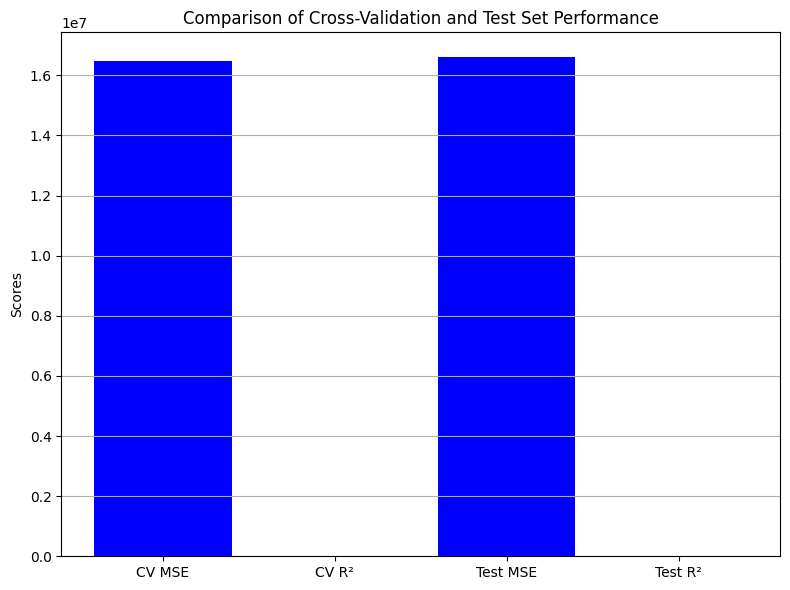

In [ ]:
# Perform K-Fold Cross-Validation on the optimized model
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_mse = cross_val_score(optimized_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(optimized_pipeline, X_train, y_train, cv=kfold, scoring='r2')

# Mean cross-validation results
mean_cv_mse = -np.mean(cv_scores_mse)
mean_cv_r2 = np.mean(cv_scores_r2)

# Print results
print(f'K-Fold Cross-Validation MSE (mean): {mean_cv_mse:.4f}')
print(f'K-Fold Cross-Validation R² (mean): {mean_cv_r2:.4f}')
print(f'Test Set MSE: {mse_optimized:.4f}')
print(f'Test Set R²: {r2_optimized:.4f}')

# Create a bar chart to visualize the performance comparison
metrics = ['CV MSE', 'CV R²', 'Test MSE', 'Test R²']
values = [mean_cv_mse, mean_cv_r2, mse_optimized, r2_optimized]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'blue', 'green'])
plt.title('Comparison of Cross-Validation and Test Set Performance')
plt.ylabel('Scores')
plt.grid(True, axis='y')

# Display the plot
plt.tight_layout()
plt.show()


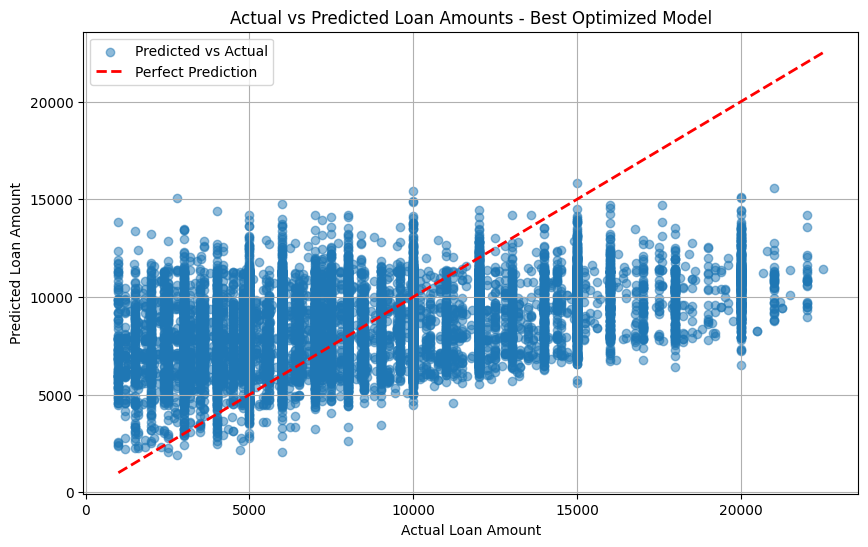

Optimized Model - Mean Squared Error: 16597550.5065
Optimized Model - R² Score: 0.1824


In [ ]:
# Fit the optimized model on the training set
optimized_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_optimized = optimized_pipeline.predict(X_test)

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimized, alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Perfect Prediction", linewidth=2)
plt.title("Actual vs Predicted Loan Amounts - Best Optimized Model")
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.legend()
plt.grid(True)
plt.show()

# Optionally, print out the evaluation metrics
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)
print(f'Optimized Model - Mean Squared Error: {mse_optimized:.4f}')
print(f'Optimized Model - R² Score: {r2_optimized:.4f}')


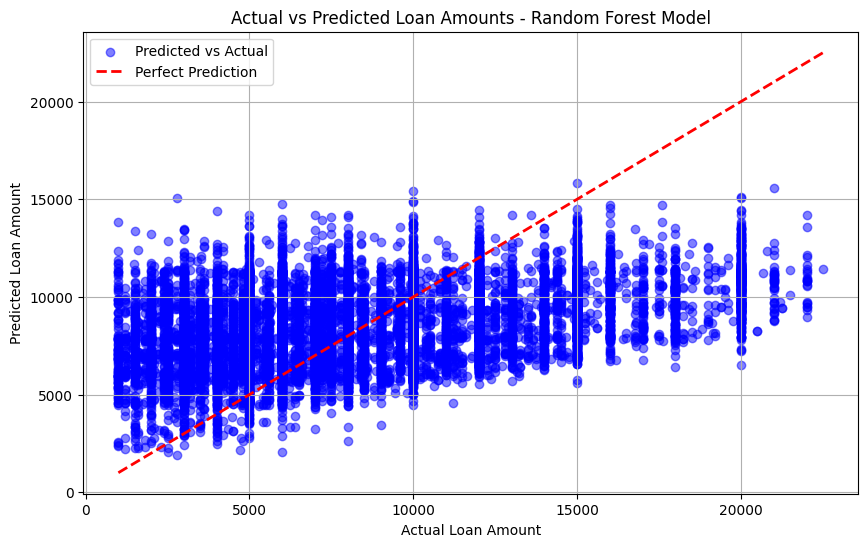

Random Forest Model - Mean Squared Error: 16597550.5065
Random Forest Model - R² Score: 0.1824


In [ ]:
# Fit the Random Forest model on the training set
optimized_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = optimized_pipeline.predict(X_test)

# Plot Actual vs Predicted values for the Random Forest model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Predicted vs Actual", color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Perfect Prediction", linewidth=2)
plt.title("Actual vs Predicted Loan Amounts - Random Forest Model")
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.legend()
plt.grid(True)
plt.show()

# Print evaluation metrics for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Model - Mean Squared Error: {mse_rf:.4f}')
print(f'Random Forest Model - R² Score: {r2_rf:.4f}')


K-Fold Cross-Validation MSE (mean): 16469071.5150
K-Fold Cross-Validation R² (mean): 0.1823
Test Set MSE: 16597550.5065
Test Set R²: 0.1824


2024/11/02 21:27:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


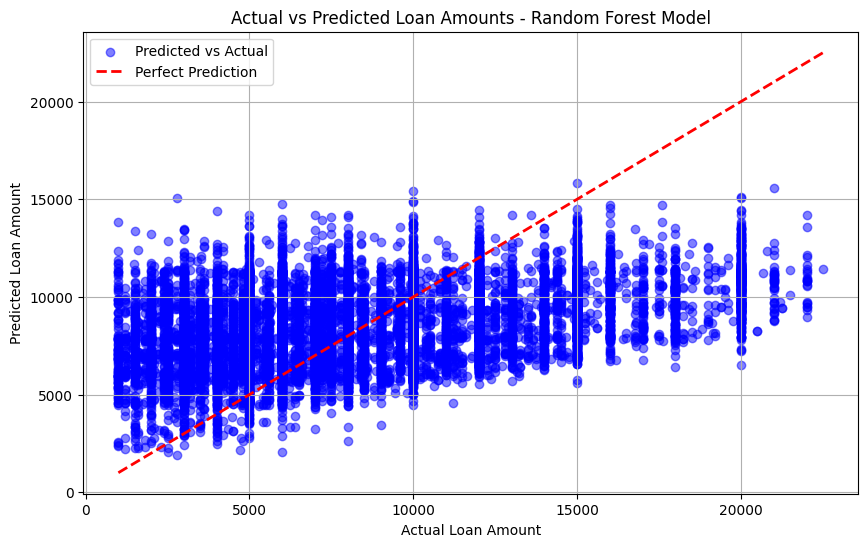

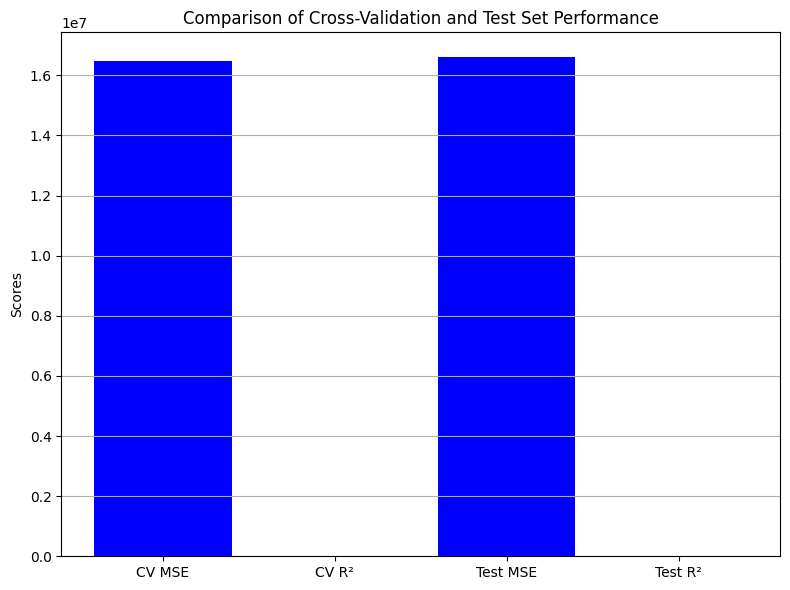

In [ ]:
# Perform K-Fold Cross-Validation on the optimized RandomForest model
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Assuming you have already defined 'optimized_pipeline' with RandomForest
# Evaluate using negative MSE and R² score on training data (cross-validation)
cv_scores_mse = cross_val_score(optimized_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(optimized_pipeline, X_train, y_train, cv=kfold, scoring='r2')

# Mean cross-validation results
mean_cv_mse = -np.mean(cv_scores_mse)
mean_cv_r2 = np.mean(cv_scores_r2)

# Print K-Fold Cross-Validation results
print(f'K-Fold Cross-Validation MSE (mean): {mean_cv_mse:.4f}')
print(f'K-Fold Cross-Validation R² (mean): {mean_cv_r2:.4f}')

# Fit the optimized model on the training set (Random Forest)
optimized_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = optimized_pipeline.predict(X_test)

# Evaluate the model on the test set
test_mse_rf = mean_squared_error(y_test, y_pred_rf)
test_r2_rf = r2_score(y_test, y_pred_rf)

# Print test results
print(f'Test Set MSE: {test_mse_rf:.4f}')
print(f'Test Set R²: {test_r2_rf:.4f}')

# Logging everything to MLflow
with mlflow.start_run(run_name="Random_Forest_Optimized"):
    # Log hyperparameters (best_params is assumed to be set)
    mlflow.log_params(best_params)
    
    # Log K-Fold Cross-Validation metrics
    mlflow.log_metric('mean_cv_mse', mean_cv_mse)
    mlflow.log_metric('mean_cv_r2', mean_cv_r2)
    
    # Log test metrics
    mlflow.log_metric('test_mse_rf', test_mse_rf)
    mlflow.log_metric('test_r2_rf', test_r2_rf)
    
    # Log the trained model
    mlflow.sklearn.log_model(optimized_pipeline, "optimized_random_forest")

# Plotting actual vs predicted values for Random Forest Regressor
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Predicted vs Actual", color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Perfect Prediction", linewidth=2)
plt.title("Actual vs Predicted Loan Amounts - Random Forest Model")
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.legend()
plt.grid(True)
plt.show()

# Create a bar chart to visualize the performance comparison
metrics = ['CV MSE', 'CV R²', 'Test MSE', 'Test R²']
values = [mean_cv_mse, mean_cv_r2, test_mse_rf, test_r2_rf]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'blue', 'green'])
plt.title('Comparison of Cross-Validation and Test Set Performance')
plt.ylabel('Scores')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


In [ ]:

# 2. Load and explore the dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Combine the training and test datasets for consistent preprocessing
combine = pd.concat([test, train], axis=0)

# 3. Data Preprocessing
# Drop 'loan_status' if it's still present
df = combine.drop("loan_status", axis=1, errors='ignore')

# Handle missing values (fill missing with mean for numerical columns)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Drop duplicates
df = df.drop_duplicates()

In [ ]:
# Define target variable and features
target_variable = 'loan_amnt'
X = df.drop(columns=[target_variable])  # Features (all columns except the target)
y = df[target_variable]  # Target variable

# Define numerical and categorical features
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Create a Preprocessor for scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical features
    ])

# 5. Optuna Hyperparameter Tuning Function for Random Forest
def objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Define the model with the trial's parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Create a pipeline with the preprocessor and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Perform cross-validation to evaluate the model
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')

    return np.mean(cv_scores)

# Create an Optuna study to optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Run optimization for 50 trials

# Retrieve the best hyperparameters from Optuna
best_params = study.best_params
print("Best Hyperparameters from Optuna:", best_params)

# 6. Train the Optimized Random Forest Model with the Best Hyperparameters
optimized_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Create a pipeline with the optimized model
optimized_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', optimized_model)
])

# Fit the model on the training set
optimized_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_optimized = optimized_pipeline.predict(X_test)

# Evaluate the model on the test set
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f'Optimized Model - Test MSE: {mse_optimized:.4f}')
print(f'Optimized Model - Test R² Score: {r2_optimized:.4f}')

# 7. Log Results to MLflow
with mlflow.start_run(run_name="Optimized_Random_Forest"):
    mlflow.log_params(best_params)
    mlflow.log_metric('Test MSE', mse_optimized)
    mlflow.log_metric('Test R²', r2_optimized)
    mlflow.sklearn.log_model(optimized_pipeline, "random_forest_model")

# 8. Plot Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimized, alpha=0.5, label="Predicted vs Actual", color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Perfect Prediction", linewidth=2)
plt.title("Actual vs Predicted Loan Amounts - Optimized Random Forest")
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.legend()
plt.grid(True)
plt.show()

# 9. K-Fold Cross-Validation with Final Optimized Model
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_mse = cross_val_score(optimized_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(optimized_pipeline, X_train, y_train, cv=kfold, scoring='r2')

mean_cv_mse = -np.mean(cv_scores_mse)
mean_cv_r2 = np.mean(cv_scores_r2)

print(f'K-Fold Cross-Validation MSE (mean): {mean_cv_mse:.4f}')
print(f'K-Fold Cross-Validation R² (mean): {mean_cv_r2:.4f}')

# 10. Plot Comparison of Cross-Validation and Test Set Performance
metrics = ['CV MSE', 'CV R²', 'Test MSE', 'Test R²']
values = [mean_cv_mse, mean_cv_r2, mse_optimized, r2_optimized]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'blue', 'green'])
plt.title('Comparison of Cross-Validation and Test Set Performance')
plt.ylabel('Scores')
plt.grid(True, axis='y')
plt.show()


[I 2024-11-02 21:27:39,484] A new study created in memory with name: no-name-f9d7e337-780f-4a68-a981-b82122d2efb3
[I 2024-11-02 21:32:06,044] Trial 0 finished with value: 0.9784414846932101 and parameters: {'n_estimators': 307, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9784414846932101.
[I 2024-11-02 21:32:58,109] Trial 1 finished with value: 0.9743445470024051 and parameters: {'n_estimators': 115, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9784414846932101.
[I 2024-11-02 21:37:21,019] Trial 2 finished with value: 0.9783451721939869 and parameters: {'n_estimators': 422, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9784414846932101.
[I 2024-11-02 21:47:41,958] Trial 3 finished with value: 0.9805825221559864 and parameters: {'n_estimators': 604, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 3 with value:

KeyboardInterrupt: 

Optimized Model - Test MSE: 650019.5194
Optimized Model - Test R² Score: 0.9789


2024/10/24 00:12:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


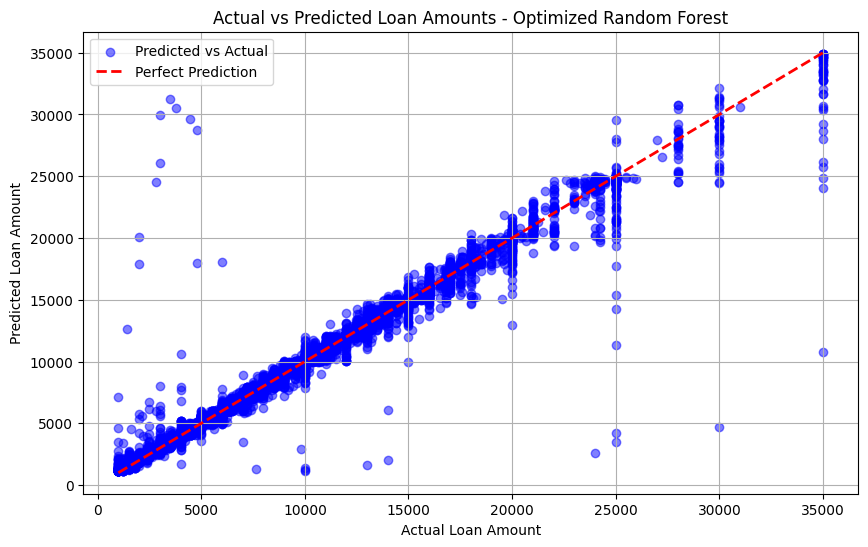

K-Fold Cross-Validation MSE (mean): 618431.5546
K-Fold Cross-Validation R² (mean): 0.9801


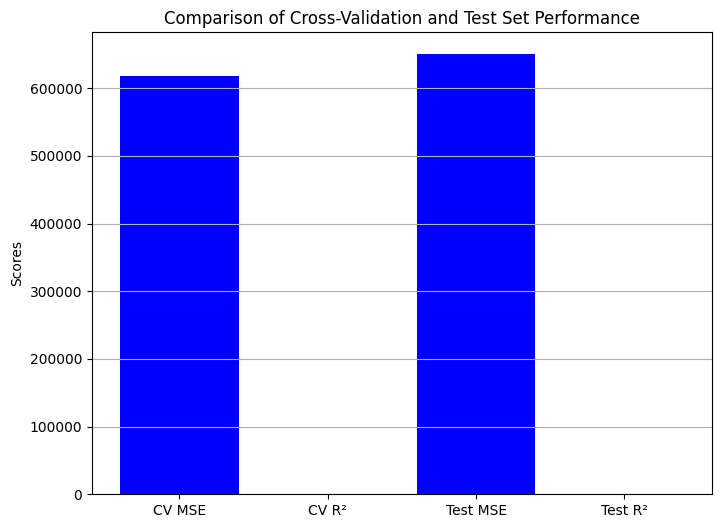

In [ ]:
# 6. Train the Optimized Random Forest Model with the Best Hyperparameters
optimized_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Create a pipeline with the optimized model
optimized_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', optimized_model)
])

# Fit the model on the training set
optimized_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_optimized = optimized_pipeline.predict(X_test)

# Evaluate the model on the test set
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f'Optimized Model - Test MSE: {mse_optimized:.4f}')
print(f'Optimized Model - Test R² Score: {r2_optimized:.4f}')

# 7. Log Results to MLflow
with mlflow.start_run(run_name="Optimized_Random_Forest"):
    mlflow.log_params(best_params)
    mlflow.log_metric('Test MSE', mse_optimized)
    mlflow.log_metric('Test R²', r2_optimized)
    mlflow.sklearn.log_model(optimized_pipeline, "random_forest_model")

# 8. Plot Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimized, alpha=0.5, label="Predicted vs Actual", color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Perfect Prediction", linewidth=2)
plt.title("Actual vs Predicted Loan Amounts - Optimized Random Forest")
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.legend()
plt.grid(True)
plt.show()

# 9. K-Fold Cross-Validation with Final Optimized Model
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_mse = cross_val_score(optimized_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(optimized_pipeline, X_train, y_train, cv=kfold, scoring='r2')

mean_cv_mse = -np.mean(cv_scores_mse)
mean_cv_r2 = np.mean(cv_scores_r2)

print(f'K-Fold Cross-Validation MSE (mean): {mean_cv_mse:.4f}')
print(f'K-Fold Cross-Validation R² (mean): {mean_cv_r2:.4f}')

# 10. Plot Comparison of Cross-Validation and Test Set Performance
metrics = ['CV MSE', 'CV R²', 'Test MSE', 'Test R²']
values = [mean_cv_mse, mean_cv_r2, mse_optimized, r2_optimized]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'blue', 'green'])
plt.title('Comparison of Cross-Validation and Test Set Performance')
plt.ylabel('Scores')
plt.grid(True, axis='y')
plt.show()
